# FI-2Pop demo

Demo notebook on the integration of FI-2Pop with the L-System.

## Imports

In [1]:
import json

GECCO-compatible `matplotlib` options:

In [2]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import `PCGSEPy` modules:

In [3]:
from pcgsepy.common.vecs import orientation_from_str, Vec 
from pcgsepy.config import COMMON_ATOMS, HL_ATOMS, N_ITERATIONS, REQ_TILES 
from pcgsepy.lsystem.rules import RuleMaker
from pcgsepy.lsystem.actions import AtomAction, Rotations
from pcgsepy.lsystem.parser import HLParser, LLParser
from pcgsepy.lsystem.solver import LSolver
from pcgsepy.lsystem.constraints import ConstraintHandler, ConstraintLevel, ConstraintTime
from pcgsepy.lsystem.constraints_funcs import components_constraint, intersection_constraint, symmetry_constraint, wheels_plane_constraint
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.structure import block_definitions

## Setup

In [4]:
# import logging

# logging.basicConfig()
# logger = logging.getLogger('base-logger')
# logger.setLevel(logging.WARNING)

In [5]:
with open(COMMON_ATOMS, "r") as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]["action"], common_alphabet[k]["args"]
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {"action": action, "args": args}

In [6]:
with open(HL_ATOMS, "r") as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
tiles_block_offset = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]["dimensions"]
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)
    tiles_block_offset[tile] = hl_atoms[tile]["offset"]

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

In [7]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]

for k in block_definitions.keys():
    if k != "":  # TODO: This is a probable bug, reported to the SE API devs
        ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## L-System components

In [8]:
hl_rules = RuleMaker(ruleset='hlrules').get_rules()
ll_rules = RuleMaker(ruleset='llrules').get_rules()

hl_parser = HLParser(rules=hl_rules)
ll_parser = LLParser(rules=ll_rules)

hl_solver = LSolver(parser=hl_parser,
                    atoms_alphabet=hl_alphabet,
                    extra_args={
                        'tiles_dimensions': tiles_dimensions,
                        'tiles_block_offset': tiles_block_offset,
                        'll_rules': ll_rules
                    })
ll_solver = LSolver(parser=ll_parser,
                    atoms_alphabet=dict(hl_alphabet, **ll_alphabet),
                    extra_args={})

In [9]:
rcc1 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc1.extra_args["req_tiles"] = ['cockpit']

rcc2 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc2.extra_args["req_tiles"] = ['corridorcargo', 'corridorgyros', 'corridorreactors']

rcc3 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc3.extra_args["req_tiles"] = ['thrusters']

nic = ConstraintHandler(
    name="no_intersections",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.DURING,
    f=intersection_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    },
    needs_ll=True
)
nic.extra_args["tiles_dimensions"] = tiles_dimensions

sc = ConstraintHandler(
    name="symmetry",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=symmetry_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

In [10]:
lsystem = LSystem(
    hl_solver=hl_solver, ll_solver=ll_solver, names=['HeadModule', 'BodyModule', 'TailModule']
)

In [11]:
lsystem.add_hl_constraints(cs=[
    [nic, rcc1],
    [nic, rcc2],
    [nic, rcc3]
])

lsystem.add_ll_constraints(cs=[
    [sc],
    [sc],
    [sc]
])

## FI-2Pop

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:2.1798833333333327;m:1.1943875
Created Infeasible population of size 20: t:1;m:1.35


Generation :   0%|          | 0/20 [00:00<?, ?it/s]

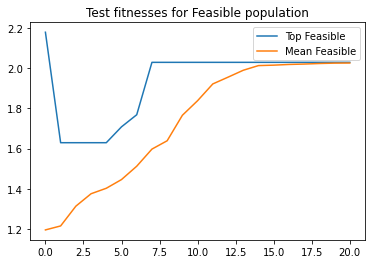

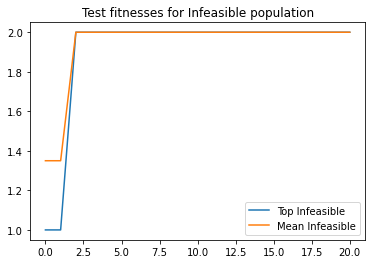

In [12]:
from pcgsepy.evo.fitness import box_filling_fitness
from pcgsepy.fi2pop.fi2pop import FI2PopSolver
from pcgsepy.config import N_GENS

fitnesses = [box_filling_fitness]

solver = FI2PopSolver(feasible_fitnesses=fitnesses,
                      lsystem=lsystem)

f_pop, i_pop, f_fitnesses, i_fitnesses = solver.initialize()

f_pop, i_pop, f_fitnesses, i_fitnesses = solver.fi2pop(f_pop=f_pop,
                                                       i_pop=i_pop,
                                                       f_fitnesses=f_fitnesses,
                                                       i_fitnesses=i_fitnesses,
                                                       n_iter=N_GENS)

solver.plot_trackings(title='Test fitnesses')

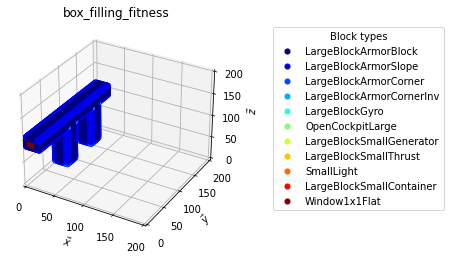

In [14]:
from pcgsepy.lsystem.structure_maker import LLStructureMaker
from pcgsepy.common.vecs import Orientation
from pcgsepy.structure import Structure

hl_axiom = f_pop[f_fitnesses.index(max(f_fitnesses))]
ml_axiom = lsystem.hl_solver.translator.transform(axiom=hl_axiom)
ll_axiom = lsystem.ll_solver.solve(axiom=ml_axiom,
                                  iterations=1,
                                  axioms_per_iteration=1,
                                  check_sat=False)[0]

base_position, orientation_forward, orientation_up = Vec.v3i(
            0, 0, 0), Orientation.FORWARD.value, Orientation.UP.value
structure = Structure(origin=base_position,
                      orientation_forward=orientation_forward,
                      orientation_up=orientation_up)
structure = LLStructureMaker(
    atoms_alphabet=lsystem.ll_solver.atoms_alphabet,
    position=base_position).fill_structure(structure=structure,
                                           axiom=ll_axiom)
structure.sanify()
structure.show(title=' + '.join([f.__name__ for f in fitnesses]))

In [15]:
print(f'HL AXIOM:\n\t{hl_axiom}\n---\nML AXIOM:\n\t{ml_axiom}\n---\nLL AXIOM:\n\t{ll_axiom}')

HL AXIOM:
	cockpitcorridorsimple(1)corridorcargo(2)corridorreactors(1)[RotYcwZcorridorsimple(5)]corridorsimple(1)corridorgyros(2)[RotYcwZcorridorsimple(5)]corridorreactors(1)thrusters
---
ML AXIOM:
	cockpit!(15)corridorsimple!(15)corridorcargo!(15)corridorcargo!(15)corridorreactors!(15)[>(5)RotYcwZcorridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorwall!(10)]YcwZintersection!(25)corridorsimple!(15)corridorgyros!(15)corridorgyros!(15)[>(5)RotYcwZcorridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorsimple!(15)corridorwall!(10)]YcwZintersection!(25)corridorreactors!(15)thrusters!(15)
---
LL AXIOM:
	LargeBlockArmorSlope(B,L)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorSlope(B,R)!(5)-(20)LargeBlockArmorSlope(B,L)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorSlope(B,R)!(5)-(20)LargeBlockArmor

In [16]:
do_place_blocks = False

In [17]:
if do_place_blocks:
    from pcgsepy.common.api_call import GameMode, get_base_values, toggle_gamemode
    from pcgsepy.structure import place_blocks
    
    base_position, orientation_forward, orientation_up = get_base_values()
    structure.update(
        origin=base_position,
        orientation_forward=orientation_forward,
        orientation_up=orientation_up,
    )
    toggle_gamemode(GameMode.PLACING)
    place_blocks(structure.get_all_blocks(), False)
    toggle_gamemode(GameMode.EVALUATING)